# Split Dataset

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
annotations_csv =  "../data_round_2/phase2_train_v0_cleaned.csv"
annotations_csv2 = "../data_round_2/phase2_train_v0.csv"

df1 = pd.read_csv(annotations_csv)
df2 = pd.read_csv(annotations_csv2)

train_df, val_df = train_test_split(
            df2,
            test_size=0.2,
            stratify=df2["class_label"],
            random_state=200,
        )

    
val_fname = list(set(val_df["img_fName"]))
train_fname = list(set(train_df["img_fName"]))

val_df = df1[df1["img_fName"].isin(val_fname)]
train_df = df1[df1["img_fName"].isin(train_fname)]

val_df.to_csv("../data_round_2/phase2_train_v0_cleaned_train_annotations.csv", index=False)
train_df.to_csv("../data_round_2/phase2_train_v0_cleaned_val_annotations.csv", index=False)

In [8]:
import pandas as pd
from sklearn.model_selection import train_test_split

annotations_csv1 = "../data_round_2/phase2_train_v0_cleaned_yolo_best_annotations.csv"
annotations_csv2 = "../data_round_2/phase2_train_v0.csv"
df1 = pd.read_csv(annotations_csv1)
df2 = pd.read_csv(annotations_csv2)

In [9]:
train_df, val_df = train_test_split(
            df2,
            test_size=0.2,
            stratify=df2["class_label"],
            random_state=200,
        )
val_df.to_csv("../data_round_2/val_data_origina_data.csv", index=False)


In [7]:
train_df, val_df = train_test_split(
            df2,
            test_size=0.2,
            stratify=df2["class_label"],
            random_state=200,
        )

val_fname = list(set(val_df["img_fName"]))
train_fname = list(set(train_df["img_fName"]))

val_df = df1[df1["img_fName"].isin(val_fname)]
train_df = df1[df1["img_fName"].isin(train_fname)]

val_df.to_csv("../data_round_2/best_model_val_data_yolo_annotations.csv", index=False)
train_df.to_csv("../data_round_2/best_model_train_data_yolo_annotations.csv", index=False)

In [5]:
_, val_df = train_test_split(
            df1,
            test_size=0.2,
            stratify=df1["class_label"],
            random_state=200,
        )

val_fname = list(set(val_df["img_fName"]))
val_df = df2[df2["img_fName"].isin(val_fname)]
val_df.to_csv("../data_round_2/val_data_yolo_annotations_val_images.csv", index=False)


In [2]:
val_fname = list(set(val_df["img_fName"]))

_train_data, _val_data = train_test_split(
    df_img_label,
    test_size=0.2,
    stratify=df_img_label["class_label"],
    random_state=200,
)

_train_list = list(set(_train_data["img_fName"]))
_val_list = list(set(_val_data["img_fName"]))

train_df = df[df['img_fName'].isin(_train_list)]
val_df = df[df["img_fName"].isin(_val_list)]

In [13]:
len(train_df), len(val_df)

(8461, 2115)

In [14]:
len(_train_list), len(_val_list)

(8285, 2072)

In [3]:
annotations_csv = "../data_round_2/phase2_train_v0.csv"
df = pd.read_csv(annotations_csv)

In [4]:
val_df = df[df["img_fName"].isin(_val_list)]
val_df.to_csv("../data_round_2/val_data_2.csv", index=False)

# YOLO and OWL-ViT Check Annotation Quality

In [43]:
import os 
import json
import copy

from tqdm import tqdm
import pandas as pd
from ultralytics import YOLO
from PIL import Image, ImageDraw
import PIL
from transformers import OwlViTProcessor, OwlViTForObjectDetection
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

PIL.Image.MAX_IMAGE_PIXELS = 108000001

%matplotlib inline  
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [44]:
img_dir = "../data_round_2/final"
annotations_csv = "../data_round_2/phase2_train_v0_cleaned.csv"
yolo_path = 'yolo/runs/detect/train5/weights/best.pt'

In [45]:
det = YOLO(yolo_path, task="detect")
df = pd.read_csv(annotations_csv)
imgs_list = list(set(df["img_fName"]))
_, val_list = train_test_split(
    imgs_list,
    test_size=0.2,
    random_state=200,
)
df = df[df['img_fName'].isin(val_list)]
owl_processor = OwlViTProcessor.from_pretrained("google/owlvit-base-patch32", cache_dir='models/owl/')
owl_model = OwlViTForObjectDetection.from_pretrained("google/owlvit-base-patch32", cache_dir='models/owl/').cuda()

In [46]:
def nms_pytorch(P : torch.tensor ,thresh_iou : float):
    """
    Apply non-maximum suppression to avoid detecting too many
    overlapping bounding boxes for a given object.
    Args:
        boxes: (tensor) The location preds for the image 
            along with the class predscores, Shape: [num_boxes,5].
        thresh_iou: (float) The overlap thresh for suppressing unnecessary boxes.
    Returns:
        A list of filtered boxes, Shape: [ , 5]

    Not smart so copy paste:
        https://learnopencv.com/non-maximum-suppression-theory-and-implementation-in-pytorch/
    """
 
    # we extract coordinates for every 
    # prediction box present in P
    x1 = P[:, 0]
    y1 = P[:, 1]
    x2 = P[:, 2]
    y2 = P[:, 3]
 
    # we extract the confidence scores as well
    scores = P[:, 4]
 
    # calculate area of every block in P
    areas = (x2 - x1) * (y2 - y1)
     
    # sort the prediction boxes in P
    # according to their confidence scores
    order = scores.argsort()
 
    # initialise an empty list for 
    # filtered prediction boxes
    keep = []
     
 
    while len(order) > 0:
         
        # extract the index of the 
        # prediction with highest score
        # we call this prediction S
        idx = order[-1]
 
        # push S in filtered predictions list
        keep.append(P[idx])
 
        # remove S from P
        order = order[:-1]
 
        # sanity check
        if len(order) == 0:
            break
         
        # select coordinates of BBoxes according to 
        # the indices in order
        xx1 = torch.index_select(x1,dim = 0, index = order)
        xx2 = torch.index_select(x2,dim = 0, index = order)
        yy1 = torch.index_select(y1,dim = 0, index = order)
        yy2 = torch.index_select(y2,dim = 0, index = order)
 
        # find the coordinates of the intersection boxes
        xx1 = torch.max(xx1, x1[idx])
        yy1 = torch.max(yy1, y1[idx])
        xx2 = torch.min(xx2, x2[idx])
        yy2 = torch.min(yy2, y2[idx])
 
        # find height and width of the intersection boxes
        w = xx2 - xx1
        h = yy2 - yy1
         
        # take max with 0.0 to avoid negative w and h
        # due to non-overlapping boxes
        w = torch.clamp(w, min=0.0)
        h = torch.clamp(h, min=0.0)
 
        # find the intersection area
        inter = w*h
 
        # find the areas of BBoxes according the indices in order
        rem_areas = torch.index_select(areas, dim = 0, index = order) 
 
        # find the union of every prediction T in P
        # with the prediction S
        # Note that areas[idx] represents area of S
        union = (rem_areas - inter) + areas[idx]
         
        # find the IoU of every prediction in P with S
        IoU = inter / union
 
        # keep the boxes with IoU less than thresh_iou
        mask = IoU < thresh_iou
        order = order[mask]


    boxes = [k.numpy().tolist()[:4] for k in keep]
    scores = [k.numpy().tolist()[-1] for k in keep]
    return boxes, scores

In [57]:
@torch.no_grad()
def owl_detect_images(img_path, t=0.5):
    image = Image.open(os.path.join(img_dir, img_path)).convert("RGB")
    texts = [["a photo of a mosquito"]]
    inputs = owl_processor(text=texts, images=image, return_tensors="pt").to('cuda')
    outputs = owl_model(**inputs)
    target_sizes = torch.Tensor([image.size[::-1]]).to('cuda')
    results = owl_processor.post_process_object_detection(outputs=outputs, 
                                                          target_sizes=target_sizes, 
                                                          threshold=0.1)
    boxes, scores = results[0]["boxes"].cpu().detach(), results[0]["scores"].cpu().detach()
    #print('Before nms: ', len(boxes))

    P = torch.cat((boxes, torch.unsqueeze(scores, 1)), 1)
    boxes, scores = nms_pytorch(P, t)
    #print('After nms: ', len(boxes))

    return boxes, scores

    
def detect_images(img_path, t_iou=0.5, t_conf=0.5):
    results = det(os.path.join(img_dir, img_path), iou=t_iou, verbose=False) 

    bboxes = []
    confs = []

    conf_max = 0.0
    box_max = []
    
    for result in results:
        _bboxes = result.boxes.xyxy.tolist()
        _confs = result.boxes.conf.tolist()

        for bbox, conf in zip(_bboxes, _confs):
            if conf > conf_max:
                conf_max = conf
                box_max = [bbox[0]+5, bbox[1]+5, bbox[2]-5, bbox[3]-5]
                
    bboxes.append(box_max)
    confs.append(conf_max)
                
    return bboxes, confs


def iou(box1, box2):
    area1 = (box1[2] - box1[0]) * (box1[3] - box1[1])
    area2 = (box2[2] - box2[0]) * (box2[3] - box2[1])
    
    dif_x = (min(box1[2], box2[2]) - max(box1[0], box2[0]))
    dif_y = (min(box1[3], box2[3]) - max(box1[1], box2[1]))
    
    inter = dif_x * dif_y
    
    if dif_x < 0 or dif_y < 0:
        return 0
    return inter / (area1 + area2 - inter)

def plot_image(img_path, bboxes, true_box=[], plot=True, save_dir='examples'):
    img = Image.open(os.path.join(img_dir, img_path)).convert("RGB")
    img_ = ImageDraw.Draw(img)  
    
    for bbox in bboxes:    
        img_.rectangle(bbox, fill=None, outline="blue", width=int(0.005*max(img.size)))

    if true_box:
        img_.rectangle(true_box, fill=None, outline="green", width=int(0.005*max(img.size)))

    

    if plot:
        plt.imshow(img)
    else:
        os.makedirs(save_dir, exist_ok=True)
        img.save(os.path.join(save_dir, img_path))

In [18]:
# find all the annotations 

__model = "yolo" # "owl"
annotations_owl_path = f'annoations_{__model}.json'

if not os.path.exists(annotations_owl_path):
    data = {}
    
    for img_path in tqdm(df.img_fName):
        if __model == "owl":
            boxes, scores = owl_detect_images(img_path, t=0.1) # this should be equivalent
        else:
            boxes, scores = detect_images(img_path, t_conf=0.4)
        data[img_path] = boxes

    with open(annotations_owl_path, 'w') as f:
        json.dump(data, f, indent=4)
else:
    data = json.load(open(annotations_owl_path))

NameError: name 'os' is not defined

In [49]:
# do again so I don't run 20 min of owl guy

for key, boxes in data.items():
    if len(boxes) > 1:
        P = torch.tensor([box + [len(boxes) - i] for i, box in enumerate(boxes)])
        boxes, _ = nms_pytorch(P, 0.1)
        data[key] = boxes

In [17]:
# find bad annotations

def find_bad_annotations(df, data, t=0.1):
    bad_annotations = []


    for img_name, pred_boxes in tqdm(data.items()):
        
        # god i am bad at pandas
        true_box = df[df.img_fName == img_name].values.tolist()[0][3:7]
        w, h = df[df.img_fName == img_name].values.tolist()[0][3:7] 

        good_annotation = False
        for pred_box in pred_boxes:
            if not pred_box:
                continue
                
            if iou(true_box, pred_box) >= t:
                good_annotation = True
                break

        if not good_annotation:
            bad_annotations.append(img_name)

    return bad_annotations


bad_annotations = find_bad_annotations(df, data, 0.75)

NameError: name 'data' is not defined

In [ ]:
len(bad_annotations), len(data)

In [66]:
for img_name in tqdm(bad_annotations):
    boxes = data[img_name]
    if boxes == [[]]:
        boxes = []
    true_box = df[df.img_fName == img_name].values.tolist()[0][3:7]
    plot_image(img_name, boxes, true_box, False, f'examples_failed_cases_really_bad_{__model}')


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 28.36it/s]


In [10]:
owl_better_single = [
    "train_03703.jpeg",
    "train_04702.jpeg", # combine owl and original annotations
    "train_05448.jpeg",
    "train_06174.jpeg",
    "train_06701.jpeg",
    "train_06737.jpeg",
    "train_06916.jpeg",
    "train_06988.jpeg",
    "train_07191.jpeg",
    "train_07228.jpeg",
    "train_07246.jpeg",
    "train_07364.jpeg",
    "train_07395.jpeg",
    "train_07454.jpeg",
    "train_07512.jpeg",
    "train_07550.jpeg",
    "train_07979.jpeg",
    "train_08201.jpeg",
    "train_08222.jpeg",
    "train_08306.jpeg",
    "train_08553.jpeg",
    "train_08742.jpeg",
    "train_08804.jpeg", # combine owl and original bbox
    "train_08845.jpeg",
    "train_08904.jpeg",
    "train_09022.jpeg",
    "train_09150.jpeg",
    "train_09330.jpeg",
    "train_09453.jpeg",
    "train_09825.jpeg",
    "train_10018.jpeg",
    "train_10156.jpeg",
    "train_10160.jpeg",
    "train_10209.jpeg",
    "train_10213.jpeg"
]

len(owl_better_single)

35

In [15]:
# show images with multiple detection
data_multiple = {}
for k, v in data.items():
    if len(v) > 1:
        data_multiple[k] = v
len(data_multiple)

21

In [16]:
for img_name, boxes in tqdm(data_multiple.items()):
    true_box = df[df.img_fName == img_name].values.tolist()[0][3:7]
    plot_image(img_name, boxes, true_box, False, f'example_multiple_annotations_{__model}')

100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 25.56it/s]


In [13]:
owl_better = [
    "train_00719.jpeg",
    "train_00784.jpeg", # remove the one on the most bottom
    "train_00813.jpeg",
    "train_01606.jpeg",
    "train_01705.jpeg",
    "train_01981.jpeg",
    "train_02595.jpeg",
    "train_03039.jpeg",
    "train_03238.jpeg",
    "train_03314.jpeg",
    "train_03359.jpeg",
    "train_03804.jpeg",
    "train_04132.jpeg",
    "train_04331.jpeg",
    "train_04368.jpeg",
    "train_04420.jpeg",
    "train_04570.jpeg",
    "train_04661.jpeg",
    "train_05450.jpeg",
    "train_06233.jpeg",
    "train_06445.jpeg", # remove the one on the most bottom left
    "train_06617.jpeg",
    "train_06809.jpeg",
    "train_06860.jpeg",
    "train_06903.jpeg",
    "train_06945.jpeg",
    "train_06958.jpeg",
    "train_06980.jpeg",
    "train_07008.jpeg",
    "train_07017.jpeg",
    "train_07021.jpeg",
    "train_07035.jpeg",
    "train_07085.jpeg",
    "train_07113.jpeg",
    "train_07137.jpeg",
    "train_07159.jpeg",
    "train_07196.jpeg",
    "train_07211.jpeg",
    "train_07239.jpeg",
    "train_07241.jpeg",
    "train_07286.jpeg",
    "train_07334.jpeg", # remove the smallest
    "train_07422.jpeg",
    "train_07448.jpeg",
    "train_07479.jpeg",
    "train_07512.jpeg",
    "train_07554.jpeg", # remove the smallest
    "train_07605.jpeg",
    "train_07650.jpeg",
    "train_07673.jpeg",
    "train_07680.jpeg", # remove the smallest
    "train_07720.jpeg",
    "train_07773.jpeg",
    "train_07811.jpeg", # remove the box the one on the most bottom
    "train_07832.jpeg",
    "train_07855.jpeg",
    "train_07901.jpeg",
    "train_08060.jpeg",
    "train_08084.jpeg",
    "train_08094.jpeg", # remove the smallest bbox
    "train_08236.jpeg", # one extra box the one on the right most
    "train_08250.jpeg",
    "train_08325.jpeg",
    "train_08332.jpeg",
    "train_08362.jpeg",
    "train_08407.jpeg",
    "train_08519.jpeg",
    "train_08622.jpeg",
    "train_08696.jpeg",
    "train_08739.jpeg",
    "train_08742.jpeg",
    "train_08760.jpeg",
    "train_08832.jpeg",
    "train_08891.jpeg",
    "train_08895.jpeg",
    "train_09006.jpeg",
    "train_09021.jpeg",
    "train_09078.jpeg",
    "train_09111.jpeg",
    "train_09152.jpeg",
    "train_09186.jpeg",
    "train_09232.jpeg",
    "train_09247.jpeg",
    "train_09266.jpeg",
    "train_09316.jpeg",
    "train_09326.jpeg",
    "train_09363.jpeg",
    "train_09370.jpeg",
    "train_09375.jpeg",
    "train_09480.jpeg",
    "train_09527.jpeg",
    "train_09571.jpeg",
    "train_09585.jpeg",
    "train_09619.jpeg",
    "train_09675.jpeg",
    "train_09721.jpeg",
    "train_09733.jpeg",
    "train_09754.jpeg",
    "train_09760.jpeg",
    "train_09787.jpeg",
    "train_09825.jpeg",
    "train_09828.jpeg",
    "train_09867.jpeg",
    "train_09938.jpeg",
    "train_09947.jpeg", # remove the biggest box
    "train_09970.jpeg", # remove the biggest box
    "train_10015.jpeg",
    "train_10069.jpeg",
    "train_10084.jpeg",
    "train_10114.jpeg",
    "train_10162.jpeg",
    "train_10224.jpeg",
    "train_10245.jpeg", # one extra box the one on the right most
    "train_10257.jpeg",
    "train_10298.jpeg",
]

len(owl_better)

115

In [14]:
def filter(boxes, true_boxes, img_path):
    # remove biggest
    if img_path in ["train_09947.jpeg", "train_09970.jpeg"]:
        area = 0
        i_m = -1
        for i, box in enumerate(boxes):
            _area = (box[2] - box[0]) * (box[3] - box[1])
            if area < _area:
                i_m = i
                area = _area
        if i_m > 0:
            boxes.pop(i_m)
        return boxes
    # remove smallest
    elif img_path in ["train_07680.jpeg", "train_07554.jpeg", "train_07334.jpeg"]:
        area = 1e10
        i_m = -1
        for i, box in enumerate(boxes):
            _area = (box[2] - box[0]) * (box[3] - box[1])
            if area > _area:
                i_m = i
                area = _area
        if i_m > 0:
            boxes.pop(i_m)
        return boxes
    # remove the right most
    elif img_path in ["train_08236.jpeg", "train_07811.jpeg"]:
        right = 0
        i_m = -1
        for i, box in enumerate(boxes):
            _right = box[0]
            if right < _right:
                i_m = i
                right = _right
        if i_m > 0:
            boxes.pop(i_m)
        return boxes
    # bottom
    elif img_path in ["train_00784.jpeg", "train_06445.jpeg", "train_07811.jpeg"]:
        bottom = 0
        i_m = -1
        for i, box in enumerate(boxes):
            _bottom = box[1]
            if bottom < _bottom:
                i_m = i
                bottom = _bottom
        if i_m > 0:
            boxes.pop(i_m)
        return boxes
    # merge both
    elif img_path == "train_04702.jpeg":
        boxes.append(true_boxes)
        return boxes
    # merge boxes
    elif img_path == "train_08804.jpeg":
        box = boxes[0]
        return [[min(box[0], true_boxes[0]), min(box[1], true_boxes[1]), max(box[2], true_boxes[2]), max(box[3], true_boxes[3])]]
    return boxes

In [15]:

good_annotations = list(set(owl_better_single + owl_better))
df_dict = dict(
    (d['img_fName'], [d])for d in df.to_dict('records')
)


for img_path in good_annotations:
    # merge data with df
    boxes = data[img_path]
    true_boxes = [
        df_dict[img_path][0]['bbx_xtl'], 
        df_dict[img_path][0]['bbx_ytl'], 
        df_dict[img_path][0]['bbx_xbr'], 
        df_dict[img_path][0]['bbx_ybr']
    ]
    boxes = filter(boxes, true_boxes, img_path)

    new_annotations = []
    for box in boxes:
        annot = copy.deepcopy(df_dict[img_path][0])
        annot['bbx_xtl'] = int(box[0])
        annot['bbx_ytl'] = int(box[1])
        annot['bbx_xbr'] = int(box[2])
        annot['bbx_ybr'] = int(box[3])
        new_annotations.append(annot)

    df_dict[img_path] = new_annotations
        

In [16]:
df_list = []
for _, annotations in df_dict.items():
    df_list.extend(annotations)
len(df_list), len(df), len(df_list) - len(df)

(10576, 10357, 219)

In [17]:
clean_df = pd.DataFrame(df_list)
clean_df.to_csv("../data_round_2/phase2_train_v0_cleaned.csv", index=False)

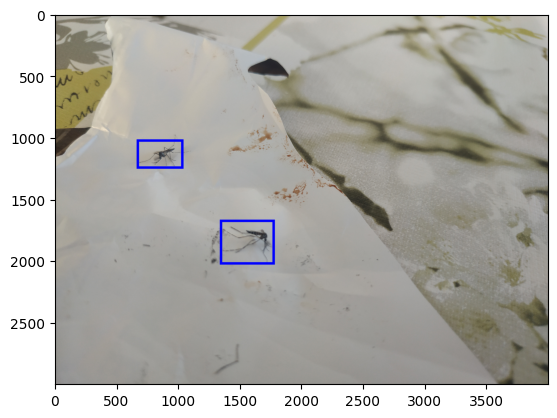

In [18]:
# some testing
img_path = 'train_06945.jpeg'

boxes = []
for annot in df_dict[img_path]:
    boxes.append( [
       annot['bbx_xtl'], 
       annot['bbx_ytl'], 
       annot['bbx_xbr'], 
       annot['bbx_ybr']
    ])

plot_image(img_path, boxes)

In [19]:
clean_df

,img_fName,img_w,img_h,bbx_xtl,bbx_ytl,bbx_xbr,bbx_ybr,class_label
0,train_00000.jpeg,2448,3264,1301,1546,1641,2096,albopictus
1,train_00001.jpeg,3024,4032,900,1897,1950,2990,albopictus
2,train_00002.jpeg,768,1024,220,58,659,808,albopictus
3,train_00003.jpeg,3456,4608,1169,2364,1586,2826,albopictus
4,train_00004.jpeg,1024,1365,129,231,697,1007,culex
...,...,...,...,...,...,...,...,...
10571,train_10352.jpeg,2064,1376,0,139,1344,1253,albopictus
10572,train_10353.jpeg,2664,3996,821,1481,1564,2706,albopictus
10573,train_10354.jpeg,1157,1157,367,315,676,764,albopictus
10574,train_10355.jpeg,3000,4000,1064,2463,1442,2917,albopictus


In [20]:
v, cc= np.unique(df['class_label'].values, return_counts=True)

In [21]:
v, c = np.unique(clean_df['class_label'].values, return_counts=True)

In [22]:
for label, new_elements in zip(v, c - cc):
    print(f'{label:<18} {str(new_elements):<3} new boxes are added.')

aegypti            1   new boxes are added.
albopictus         109 new boxes are added.
anopheles          2   new boxes are added.
culex              96  new boxes are added.
culiseta           10  new boxes are added.
japonicus/koreicus 1   new boxes are added.


In [49]:
(w > h).shape

(10576,)

In [48]:
idx.shape

(4907,)

In [44]:
w.shape, h.shape, aspect_ratio.shape, idx.shape

((10576,), (10576,), (10576,), (10576,))

In [ ]:
# B

In [22]:
import pandas as pd

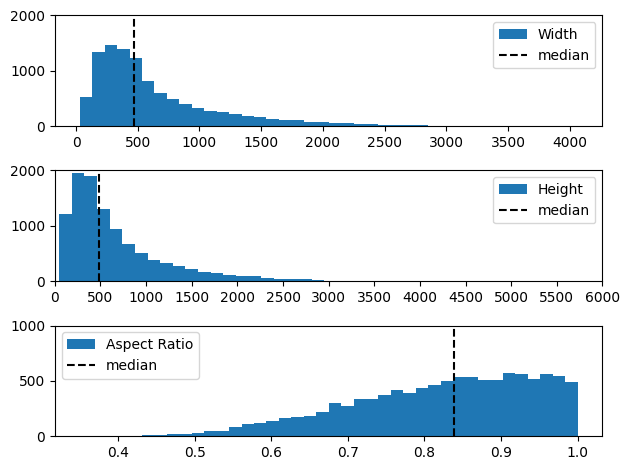

In [55]:
import numpy as np
df = pd.read_csv("../data_round_2/phase2_train_v0_cleaned.csv")


w = (df.bbx_xbr - df.bbx_xtl).values
h = (df.bbx_ybr - df.bbx_ytl).values


import matplotlib.pyplot as plt


plt.subplot(3, 1, 1)
plt.hist(w, bins=40, label="Width")
w_m = np.median(w)
plt.plot([w_m, w_m], [0, 3000], "--k", label="median")
plt.ylim(0, 2000)
plt.legend()

plt.subplot(3, 1, 2)
plt.hist(h, bins=40, label="Height")
h_m = np.median(h)
plt.plot([h_m, h_m], [0, 3000], "--k", label="median")
plt.ylim(0, 2000)
plt.xlim(0, h.max())
plt.xticks(np.arange(0, h.max() + 500, 500))
plt.legend()


plt.subplot(3, 1, 3)

idx = np.where(w > h)[0]
aspect_ratio = w / h
aspect_ratio[idx] = h[idx] / w[idx]  
plt.hist(aspect_ratio, bins=40, label="Aspect Ratio")
w_m = np.median(aspect_ratio)
plt.plot([w_m, w_m], [0, 3000], "--k", label="median")
plt.ylim(0, 1000)
plt.legend()


plt.tight_layout()